# GAP Reconstruction

Reconstructing timestamp using the logfile. We identify the regions of interest, and the UTC times they occur in and then proceed with plugging them back to the data and fixing the time. In particular we are focused on the gaps in the rate when the threshold is zero

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import raadpy as rp
import numpy as np
import os

# Define some constants
raw_dir = '../../Data/FULL_DATA/'
# SD      = '2022-09-19' 
# raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-03-04-buff1.dat', 'buff2': 'light1-2022-08-04-buff2.dat', 'buff3': 'light1-2022-08-02-buff3.dat', 'buff4': 'light1-2022-03-04-buff4.dat', 'buff5': 'light1-2022-03-04-buff5.dat', 'buff6': 'light1-2022-03-08-buff6.dat', 'buff7': 'light1-2022-03-08-buff7.dat', 'log': 'light1-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

SIPM_ID     = 0
PMT_ID      = 1
PAYLOAD_ID  = SIPM_ID

# Decode the buffer data in a dictionary
full_data   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition=f"data['id_bit'] == {PAYLOAD_ID}")

Line:   0%|          | 0/303290 [00:00<?, ?it/s]

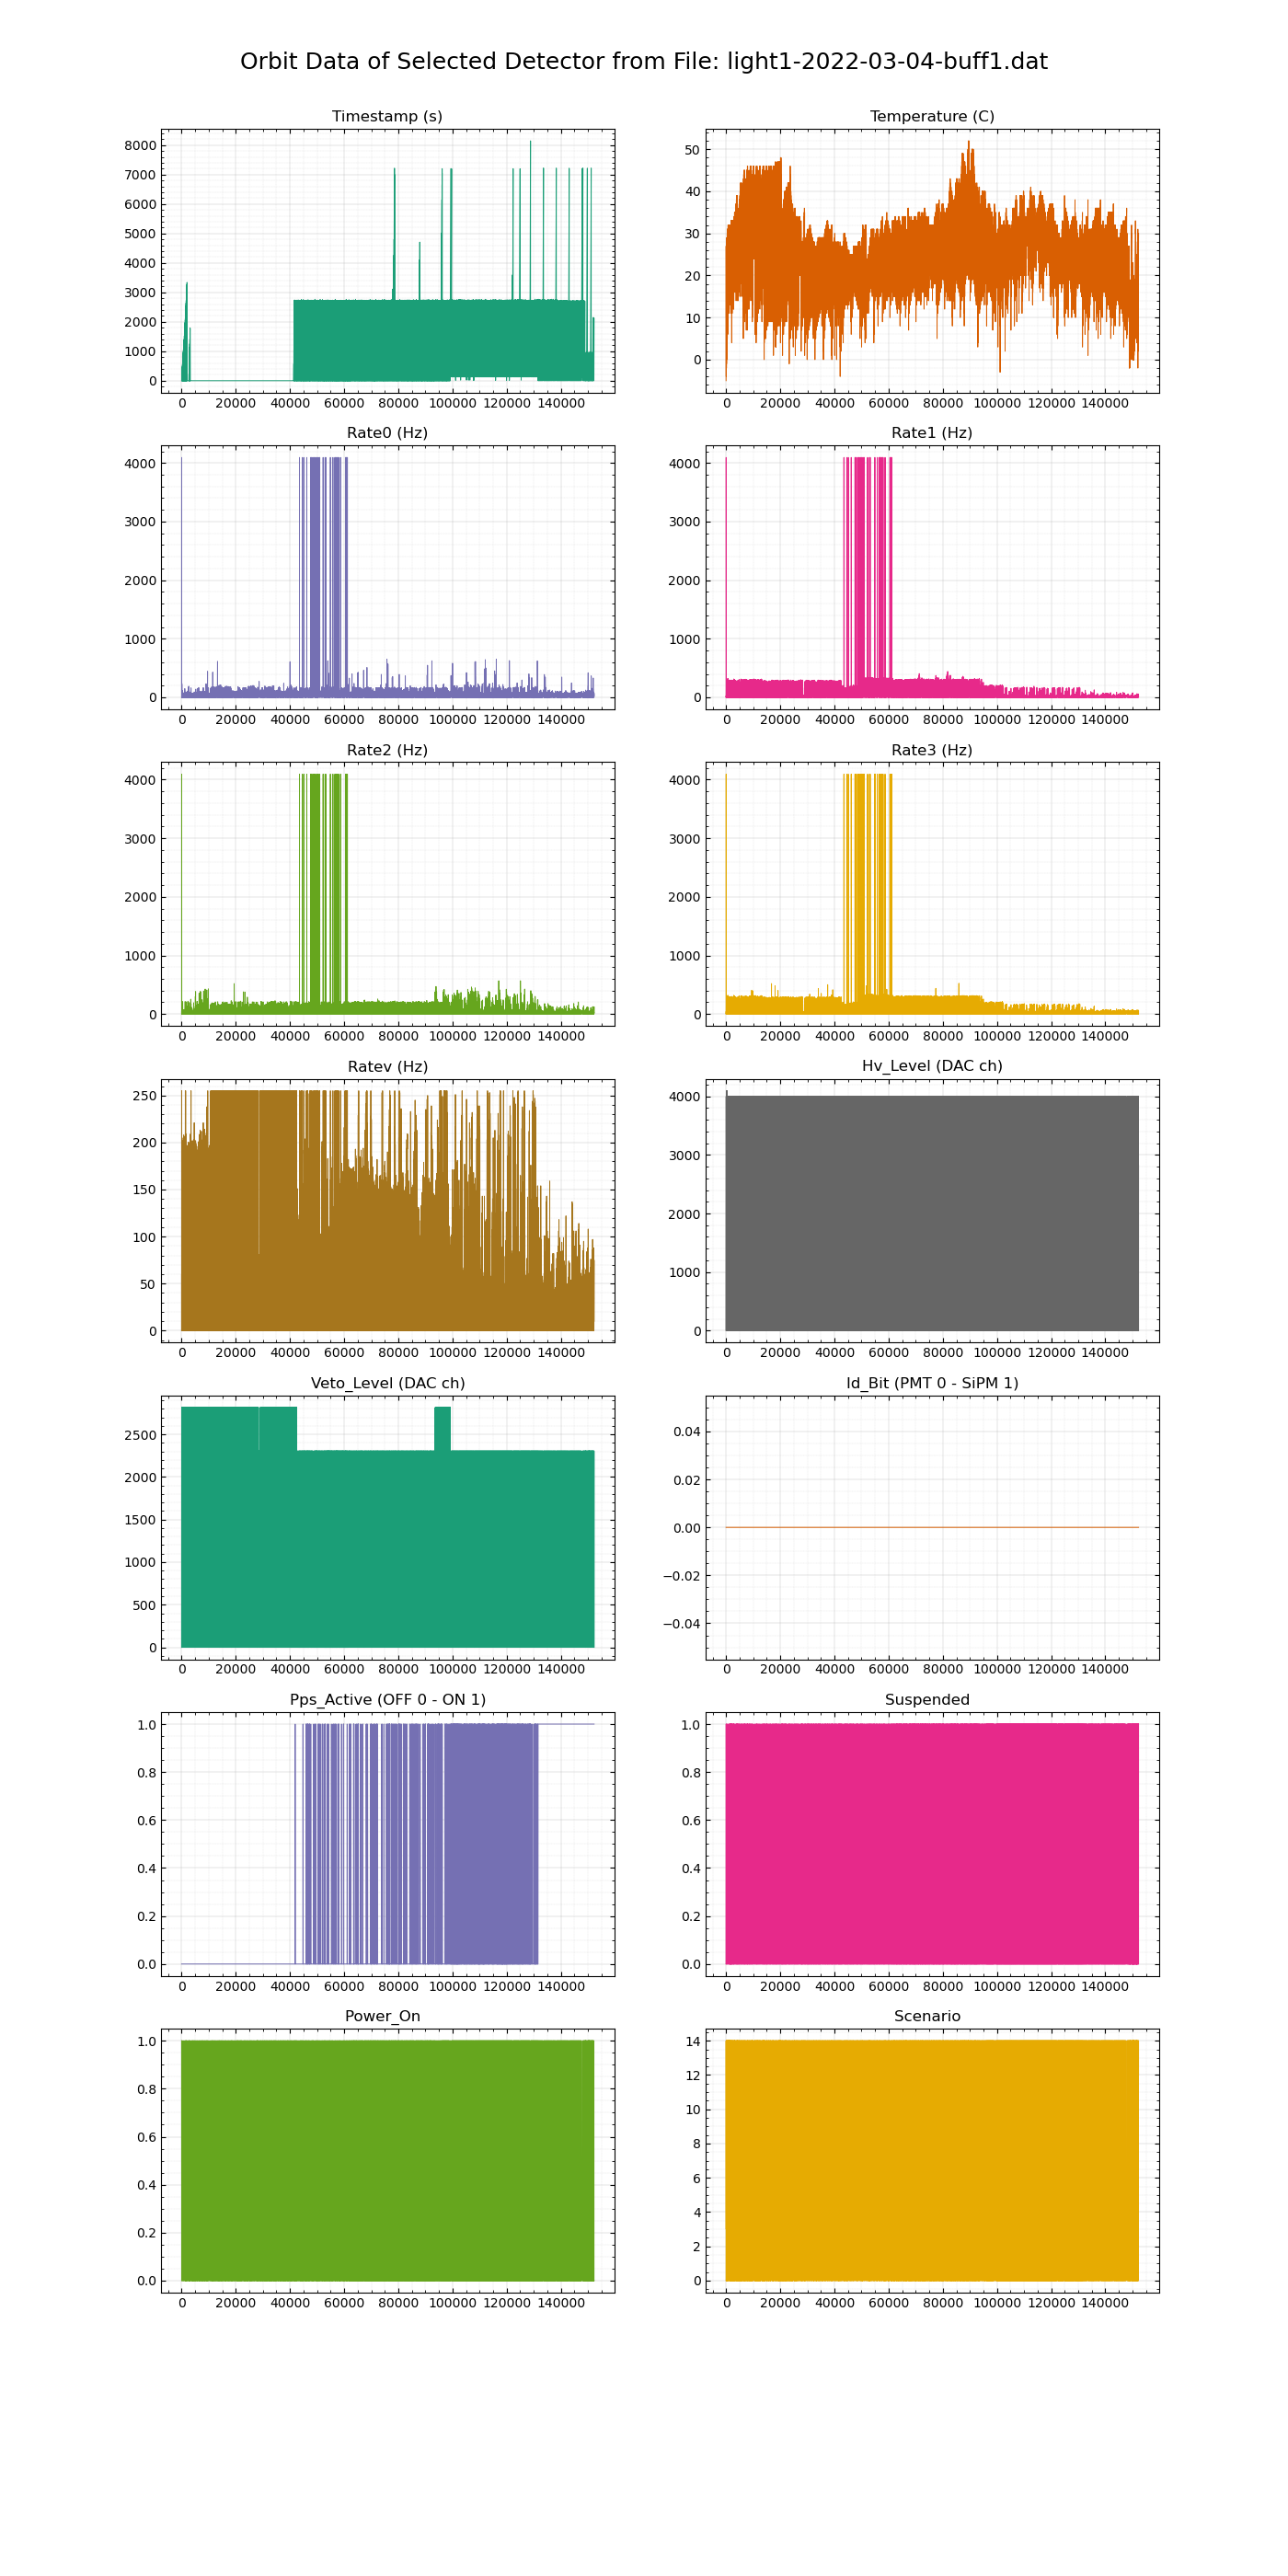

In [15]:
# Now print the Data
fig, axes  = rp.plot_buffer(full_data,title = 'Orbit Data of Selected Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

In [4]:
# Now we load the log file and find it's timestamps
log     = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log     = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing
TAIL    = 4000
data    = rp.subdict(full_data,-TAIL)

# Now we want to get only the commands that set the thresholds of all the payloads to their max
sc_commands = []
PAYLOAD     = rp.SIPM
CMD         = f"csp txrx {PAYLOAD} 9 3000 00000009FFFFFFFFFFFFFFFF"
IGNORE_FAIL = True
for line in log:
    # If This is the correct command
    if CMD in line['command']:
        # If it was executed correctly
        if IGNORE_FAIL or 'OK\n' in line['output']:
            # Append this to the high voltage commands
            sc_commands.append(line)

# Now we can see the times when the thresholds were maximized
time     = np.array([cmd['timestamp']    for cmd in sc_commands])

Found weird command
 {'command': 'SE0>script delay 45fs list\n', 'output': ['ID  Name\t   Status  Type     Entries\t  Size\n', '0   fwUpdMain      OK      STATIC   1324          917 kB\n', '1   confMain       Locked  STATIC   3422          130 kB\n', '2   confMainB      Locked  STATIC   3422          130 kB\n', '3   confFall       Locked  STATIC   3422          130 kB\n', '4   confFallB      Locked  STATIC   3422          130 kB\n', '5   generalT       OK      LOG      7887/51471    1300 kB\n', '6   dataT          OK      LOG      7887/56118    13004 kB\n', '7   startupT       OK      LOG      38/9432       650 kB\n', '8   err            Empty   LOG      -             6502 kB\n', '9   use            OK      LOG      195/48015     6502 kB\n', '10  fwUpGoldenD    Locked  STATIC   1             65 kB\n', '11  fwUpGolden     Locked  STATIC   1324          1040 kB\n', '12  SE0state       OK      LOG      106/1204      130 kB\n', '13  SE1state       Empty   LOG      -             130 kB\n', 

In [6]:
# Finding the event numbers when the rate goes to zero
# We look at the HV plot and see when that drops to zero
def trim(array):
    idx = np.where(array[1:] - array[:-1] != 0)[0] 
    return array[idx].astype(int), idx

hv_trim, hv_idx = trim(data['hv_level'][np.where(data['hv_level'] < 1)])
hv_idx_diff     = hv_idx[1:] - hv_idx[:-1]

# plt.figure()
# plt.hist(hv_idx_diff,bins=60)

print(hv_trim)


[]


In [7]:
log

[{'command': 'SE0>rtc read\n',
  'output': ['curr rtc time 1646357385.449188 s, 2022-03-04 01:29:45 \n',
   'OK\n'],
  'timestamp': -10337871.552246094},
 {'command': 'SE0># Script delay 2022-03-04:01:45:00 (avoiding SAA)\n',
  'output': [],
  'timestamp': -10337871.552246094},
 {'command': 'SE0>script delayuntil 1646358300\n',
  'output': ['OK\n'],
  'timestamp': -10336957.001434088},
 {'command': 'SE0># Enabling the PC and payload (and switching off with the timer of 30m for the payload and 3h for the PC)\n',
  'output': [],
  'timestamp': -10336957.001434088},
 {'command': 'SE0>csp txrx 4 14 600 000500302A\n',
  'output': ['Answer: 0000\n',
   'Bytes: 2\n',
   'Flags: 0x00 (frag=0, HMAC=0, XTEA=0, RDP=0, CRC32=0)\n',
   'OK\n'],
  'timestamp': -10336957.001434088},
 {'command': 'SE0>csp txrx 4 14 600 0007000807\n',
  'output': ['Answer: 0000\n',
   'Bytes: 2\n',
   'Flags: 0x00 (frag=0, HMAC=0, XTEA=0, RDP=0, CRC32=0)\n',
   'OK\n'],
  'timestamp': -10336957.001434088},
 {'command':

In [8]:
full_data['timestamp'][None:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])